# Determining convergence order for a multidimensional algorithm

In [1]:
import numpy as np
from scipy.integrate import nquad
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:
from sklearn import linear_model

In [3]:
%matplotlib inline

## Integration Algorithms

In [4]:
def midpoint_comp_2d(f, x0, x1, y0, y1, nx, ny):
    dx = (x1-x0)/nx
    dy = (y1-y0)/ny
    x = (x0 + dx * (0.5 + np.arange(nx))).reshape(nx, 1)
    y = (y0 + dy * (0.5 + np.arange(ny))).reshape(1, ny)
    
    f_vec = np.vectorize(f)
    return dx * dy * np.sum(f_vec(x, y))

def true_integral_2d(f, x0, x1, y0, y1):
    return nquad(f, ((x0, x1), (y0, y1)))

## Curve fitting

In [136]:
def robust_lin_regression(x_arr, y_arr, w=None, regressor=None):
    if regressor:
        reg = getattr(linear_model, regressor)()
    else:
        reg = linear_model.HuberRegressor()
    if len(np.shape(x_arr)) == 1:
        X = x_arr.reshape(-1, 1)
    else:
        X = x_arr
    y = y_arr
    if w is not None:
        reg.fit(X, y, sample_weight=w)
    else:
        reg.fit(X, y)
    vals = reg.predict([np.zeros_like(X[0]), np.ones_like(X[0])])
    b = vals[0]
    m = vals[1] - b
    
    return m, b

In [100]:
def robust_2d_lin_regression(x_arr, y_arr, z_arr, w=None, regressor=None):
    if regressor:
        reg = getattr(linear_model, regressor)()
    else:
        reg = linear_model.HuberRegressor()
    X = x_arr.reshape(-1, 1)
    y = y_arr
    if w is not None:
        reg.fit(X, y, sample_weight=w)
    else:
        reg.fit(X, y)
    vals = reg.predict([[0], [1]])
    b = vals[0]
    m = vals[1] - b
    
    return m, b

In [6]:
def lin_fit(x, y, x0=-np.inf, x1=np.inf):
    x_arr = np.array(x)
    y_arr = np.array(y)
    which_inds = np.logical_and(
        x_arr>=x0,
        x_arr<=x1
    )
    x_fit = x_arr[which_inds]
    y_fit = y_arr[which_inds]
    
    def resid(args):
        m, b = args
        res = np.sum((m*x_fit + b - y_fit) ** 2)
        return res
    
    m0 = 1
    b0 = 0
    res = minimize(resid, (m0, b0))
    m, b = res.x
    
    return m, b

In [7]:
def plot_lin_fit(x, y, x0, x1, xlabel='x', ylabel='y', log=True):
    xmin = np.min(x)
    ymin = np.min(y)
    xmax = np.max(x)
    ymax = np.max(y)
    
    plt.plot(x, y, 'o-')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.vlines((x0, x1), ymin, ymax, colors='k', linestyles='dashed')
    
    m, b = lin_fit(x, y, x0, x1)
    label = 'm={:.2f}, b={:.2f}'.format(m, b)
    plt.plot([xmin, xmax], [m*xmin + b, m*xmax + b], '--')
    plt.title(label)
    plt.show()

## Define function and bounds

In [8]:
def f(x, y):
    return np.sin(x) + np.sin(10*y) + (x-y)**2

In [9]:
x0 = 1
x1 = 2
y0 = 0
y1 = 4

## Plot

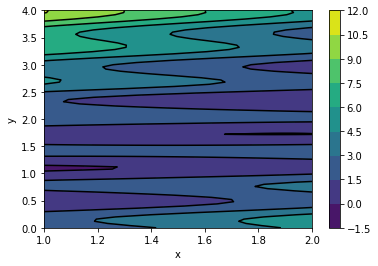

In [10]:
Nc = 101
xc = np.linspace(x0, x1, Nc)
yc = np.linspace(y0, y1, Nc)
xc, yc = np.meshgrid(xc, yc, indexing='ij')

plt.contourf(xc, yc, f(xc, yc))
plt.colorbar()
plt.contour(xc, yc, f(xc, yc), colors='k')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Calculate true solution

In [11]:
true_soln, true_err = true_integral_2d(f, x0, x1, y0, y1)
print(true_soln, true_err)

10.659157042493021 1.6371888924855e-12


## Run grid cases

In [12]:
nx_list = np.unique(np.round(np.logspace(0, 2.5, 20)).astype(int))
ny_list = np.unique(np.round(np.logspace(0, 3.5, 20)).astype(int))

soln_arr = np.zeros([len(nx_list), len(ny_list)])
err_arr = np.zeros([len(nx_list), len(ny_list)])

for i, nx in enumerate(nx_list):
    for j, ny in enumerate(ny_list):
        approx_soln = midpoint_comp_2d(f, x0, x1, y0, y1, nx, ny)
        soln_arr[i, j] = approx_soln
        err_arr[i, j] = np.abs(true_soln - approx_soln)

## Plot error

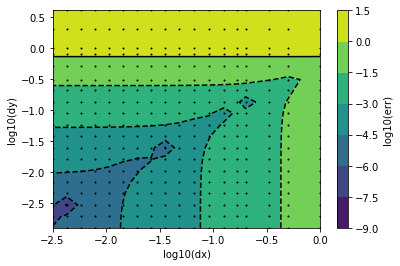

In [13]:
dx_list = (x1-x0)/np.array(nx_list)
dy_list = (y1-y0)/np.array(ny_list)

dx_grid, dy_grid = np.meshgrid(dx_list, dy_list, indexing='ij')

dx_plot = np.log10(dx_grid)
dy_plot = np.log10(dy_grid)
err_plot = np.log10(err_arr)

plt.contourf(dx_plot, dy_plot, err_plot)
plt.colorbar(label='log10(err)')
plt.plot(dx_plot, dy_plot, 'ok', ms=1)
plt.contour(dx_plot, dy_plot, err_plot, colors='k')
plt.xlabel('log10(dx)')
plt.ylabel('log10(dy)')
plt.show()

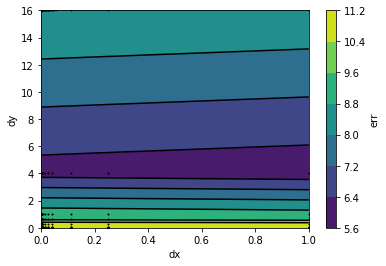

In [37]:
dx_list = (x1-x0)/np.array(nx_list)
dy_list = (y1-y0)/np.array(ny_list)

dx_grid, dy_grid = np.meshgrid(dx_list, dy_list, indexing='ij')

dx_plot = dx_grid**2
dy_plot = dy_grid**2
err_plot = soln_arr

plt.contourf(dx_plot, dy_plot, err_plot)
plt.colorbar(label='err')
plt.plot(dx_plot, dy_plot, 'ok', ms=1)
plt.contour(dx_plot, dy_plot, err_plot, colors='k')
plt.xlabel('dx')
plt.ylabel('dy')
plt.show()

In [14]:
true_soln

10.659157042493021

In [15]:
dy_grid[0,:]

array([4.00000000e+00, 2.00000000e+00, 1.00000000e+00, 8.00000000e-01,
       5.00000000e-01, 3.07692308e-01, 2.10526316e-01, 1.33333333e-01,
       8.88888889e-02, 5.71428571e-02, 3.77358491e-02, 2.46913580e-02,
       1.61290323e-02, 1.05540897e-02, 6.89655172e-03, 4.51467269e-03,
       2.95420975e-03, 1.93330111e-03, 1.26502214e-03])

In [16]:
soln_arr[:,-1]

array([10.49000766, 10.61596885, 10.63989017, 10.65220806, 10.65432996,
       10.65644118, 10.65772054, 10.65838471, 10.65876326, 10.65893578,
       10.65903718, 10.65909075, 10.65912213, 10.65913794, 10.65914684,
       10.65915181, 10.65915444, 10.65915588])

In [17]:
soln_arr[-1,:]

array([ 8.81090916,  6.09502269,  9.28995731,  9.39808558, 11.10545884,
       10.71748944, 10.67966905, 10.66624875, 10.66213858, 10.6603566 ,
       10.65967381, 10.65937628, 10.65924941, 10.65919556, 10.65917249,
       10.65916266, 10.65915845, 10.65915665, 10.65915588])

## Calculate error for best slices

dx


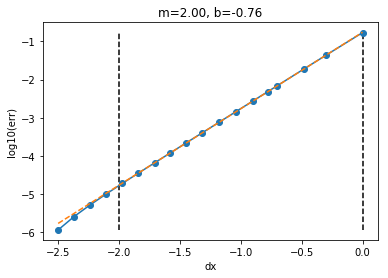

dy


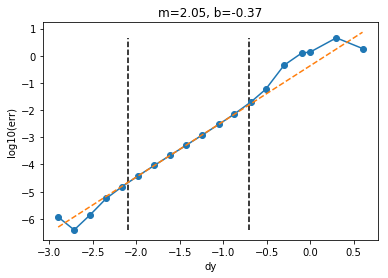

In [19]:
print("dx")
dx_slice = dx_grid[:,-1] 
err_slice = err_arr[:,-1]
plot_lin_fit(np.log10(dx_slice), np.log10(err_slice), -2, 0, xlabel='dx', ylabel='log10(err)')

print("dy")
dy_slice = dy_grid[-1,:] 
err_slice = err_arr[-1,:]
plot_lin_fit(np.log10(dy_slice), np.log10(err_slice), -2.1, -0.7, xlabel='dy', ylabel='log10(err)')

# Error estimation, Richardson extrapolation

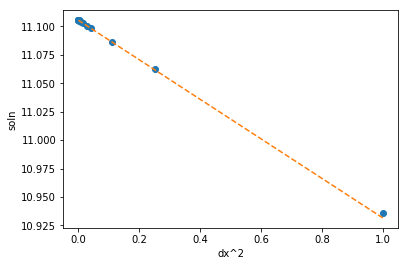

X EXTRAP
best_err: 4.46e-01, RE_err: 4.46e-01, estim_err: 5.81e-06
best_soln : 1.11054548e+01
RE_soln   : 1.11054606e+01 
true_soln : 1.06591570e+01



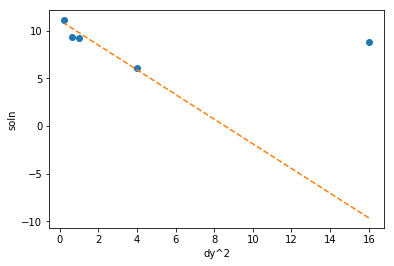

Y EXTRAP
best_err: 4.46e-01, RE_err: 4.37e-01, esim_err: 8.93e-03
best_soln : 1.11054548e+01
RE_soln   : 1.10965226e+01 
true_soln : 1.06591570e+01


In [111]:
i, j = 15, 4

inds = np.zeros_like(soln_arr, dtype=bool)
inds[:i+1, j] = True
x = dx_grid[inds]**2
y = soln_arr[inds]
soln_subset = soln_arr[inds]
m, b = robust_lin_regression(x, y, w=1/x)
#xl = np.array([np.min(x), np.max(x)])
yl = m*x + b
plt.figure()
plt.plot(x, y, 'o')
plt.plot(x, yl, '--')
plt.xlabel('dx^2')
plt.ylabel('soln')
plt.show()

best_soln = soln_subset[-1]
best_err = np.abs(true_soln - best_soln)
re_err = np.abs(true_soln - b)
estim_err = np.abs(best_soln - b)
print("X EXTRAP")
print("best_err: {:.2e}, RE_err: {:.2e}, estim_err: {:.2e}".format(best_err, re_err, estim_err))
print("{:10s}: {:.8e}".format('best_soln', best_soln))
print("{:10s}: {:.8e} ".format('RE_soln', b))
print("{:10s}: {:.8e}".format('true_soln', true_soln))
print()

inds = np.zeros_like(soln_arr, dtype=bool)
inds[i, :j+1] = True
x = dy_grid[inds]**2
y = soln_arr[inds]
soln_subset = soln_arr[inds]
m, b = robust_lin_regression(x, y, w=1/x)
#xl = np.array([np.min(x), np.max(x)])
yl = m*x + b
plt.figure()
plt.plot(x, y, 'o')
plt.plot(x, yl, '--')
plt.xlabel('dy^2')
plt.ylabel('soln')
plt.show()

best_soln = soln_subset[-1]
best_err = np.abs(true_soln - best_soln)
re_err = np.abs(true_soln - b)
estim_err = np.abs(best_soln - b)
print("Y EXTRAP")
print("best_err: {:.2e}, RE_err: {:.2e}, esim_err: {:.2e}".format(best_err, re_err, estim_err))
print("{:10s}: {:.8e}".format('best_soln', best_soln))
print("{:10s}: {:.8e} ".format('RE_soln', b))
print("{:10s}: {:.8e}".format('true_soln', true_soln))

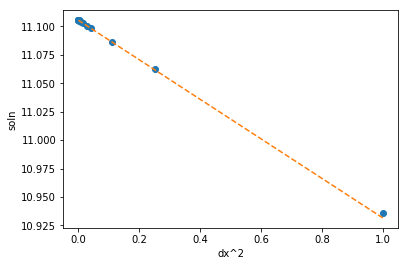

X EXTRAP
best_err: 4.46e-01, RE_err: 4.46e-01, estim_err: 5.81e-06
best_soln : 1.11054548e+01
RE_soln   : 1.11054606e+01 
true_soln : 1.06591570e+01



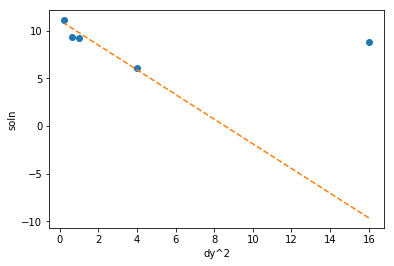

Y EXTRAP
best_err: 4.46e-01, RE_err: 4.37e-01, esim_err: 8.93e-03
best_soln : 1.11054548e+01
RE_soln   : 1.10965226e+01 
true_soln : 1.06591570e+01


In [137]:
i, j = 15, 4

# X
inds = np.zeros_like(soln_arr, dtype=bool)
inds[:i+1, j] = True
x = dx_grid[inds]**2
y = soln_arr[inds]
soln_subset = soln_arr[inds]
m, b = robust_lin_regression(x, y, w=1/x)
#xl = np.array([np.min(x), np.max(x)])
yl = m*x + b
plt.figure()
plt.plot(x, y, 'o')
plt.plot(x, yl, '--')
plt.xlabel('dx^2')
plt.ylabel('soln')
plt.show()

best_soln = soln_subset[-1]
best_err = np.abs(true_soln - best_soln)
re_err = np.abs(true_soln - b)
estim_err = np.abs(best_soln - b)
print("X EXTRAP")
print("best_err: {:.2e}, RE_err: {:.2e}, estim_err: {:.2e}".format(best_err, re_err, estim_err))
print("{:10s}: {:.8e}".format('best_soln', best_soln))
print("{:10s}: {:.8e} ".format('RE_soln', b))
print("{:10s}: {:.8e}".format('true_soln', true_soln))
print()

# Y
inds = np.zeros_like(soln_arr, dtype=bool)
inds[i, :j+1] = True
x = dy_grid[inds]**2
y = soln_arr[inds]
soln_subset = soln_arr[inds]
m, b = robust_lin_regression(x, y, w=1/x)
#xl = np.array([np.min(x), np.max(x)])
yl = m*x + b
plt.figure()
plt.plot(x, y, 'o')
plt.plot(x, yl, '--')
plt.xlabel('dy^2')
plt.ylabel('soln')
plt.show()

best_soln = soln_subset[-1]
best_err = np.abs(true_soln - best_soln)
re_err = np.abs(true_soln - b)
estim_err = np.abs(best_soln - b)
print("Y EXTRAP")
print("best_err: {:.2e}, RE_err: {:.2e}, esim_err: {:.2e}".format(best_err, re_err, estim_err))
print("{:10s}: {:.8e}".format('best_soln', best_soln))
print("{:10s}: {:.8e} ".format('RE_soln', b))
print("{:10s}: {:.8e}".format('true_soln', true_soln))

In [127]:
X.shape

(20, 2)

In [128]:
x.shape

(20,)

In [130]:
z.shape

(20,)

In [146]:
print("hi")

hi


In [ ]:
x

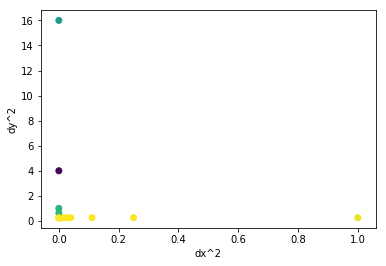

2D EXTRAP
best_err: 4.46e-01, RE_err: 4.83e-01, esim_err: 3.63e-02
best_soln : 1.11054548e+01
RE_soln   : 1.11417511e+01 
true_soln : 1.06591570e+01


In [143]:
# 2D
inds = np.zeros_like(soln_arr, dtype=bool)
inds[i, :j+1] = True
inds[:i+1, j] = True
soln_subset = soln_arr[inds]
x = dx_grid[inds]**2
y = dy_grid[inds]**2
z = soln_arr[inds]
X = np.vstack([x, y]).T
m, b = robust_lin_regression(X, z, w=np.sqrt(x+y))
#xl = np.array([np.min(x), np.max(x)])
yl = m*x + b
plt.figure()
plt.scatter(x, y, c=z)
plt.xlabel('dx^2')
plt.ylabel('dy^2')
#plt.xscale('log')
#plt.yscale('log')
plt.show()

best_soln = soln_subset[-1]
best_err = np.abs(true_soln - best_soln)
re_err = np.abs(true_soln - b)
estim_err = np.abs(best_soln - b)
print("2D EXTRAP")
print("best_err: {:.2e}, RE_err: {:.2e}, esim_err: {:.2e}".format(best_err, re_err, estim_err))
print("{:10s}: {:.8e}".format('best_soln', best_soln))
print("{:10s}: {:.8e} ".format('RE_soln', b))
print("{:10s}: {:.8e}".format('true_soln', true_soln))

In [117]:
x

array([1.00000000e+00, 2.50000000e-01, 1.11111111e-01, 4.00000000e-02,
       2.77777778e-02, 1.56250000e-02, 8.26446281e-03, 4.44444444e-03,
       2.26757370e-03, 1.27551020e-03, 6.92520776e-04, 3.84467512e-04,
       2.04081633e-04, 1.13173382e-04, 6.20001240e-05, 3.34124094e-05,
       3.34124094e-05, 3.34124094e-05, 3.34124094e-05, 3.34124094e-05])

In [118]:
y

array([ 0.25,  0.25,  0.25,  0.25,  0.25,  0.25,  0.25,  0.25,  0.25,
        0.25,  0.25,  0.25,  0.25,  0.25,  0.25, 16.  ,  4.  ,  1.  ,
        0.64,  0.25])

array([[1.00000000e+00, 2.50000000e-01],
       [2.50000000e-01, 2.50000000e-01],
       [1.11111111e-01, 2.50000000e-01],
       [4.00000000e-02, 2.50000000e-01],
       [2.77777778e-02, 2.50000000e-01],
       [1.56250000e-02, 2.50000000e-01],
       [8.26446281e-03, 2.50000000e-01],
       [4.44444444e-03, 2.50000000e-01],
       [2.26757370e-03, 2.50000000e-01],
       [1.27551020e-03, 2.50000000e-01],
       [6.92520776e-04, 2.50000000e-01],
       [3.84467512e-04, 2.50000000e-01],
       [2.04081633e-04, 2.50000000e-01],
       [1.13173382e-04, 2.50000000e-01],
       [6.20001240e-05, 2.50000000e-01],
       [3.34124094e-05, 1.60000000e+01],
       [3.34124094e-05, 4.00000000e+00],
       [3.34124094e-05, 1.00000000e+00],
       [3.34124094e-05, 6.40000000e-01],
       [3.34124094e-05, 2.50000000e-01]])

In [115]:
soln_subset

array([10.93631063, 11.06227181, 11.08619314, 11.09851102, 11.10063292,
       11.10274414, 11.1040235 , 11.10468767, 11.10506622, 11.10523875,
       11.10534014, 11.10539372, 11.10542509, 11.1054409 , 11.1054498 ,
        8.81090509,  6.09501862,  9.28995324,  9.39808151, 11.10545477])